**This is Tinghan's experiment based on "Jigsaw MpNet-Base-v2- Inference [CV 0.876]"**
- https://www.kaggle.com/code/abdmental01/jigsaw-mpnet-base-v2-inference-cv-0-876

# Configuration of experiment

In [35]:
%%time

import random
import os
import pandas as pd, numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
import re
import torch
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.serialization import add_safe_globals
import warnings 
warnings.filterwarnings('ignore')


def set_seed(seed):
    random.seed(seed)                 
    np.random.seed(seed)              
    torch.manual_seed(seed)           # PyTorch (CPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch (GPU)

    torch.backends.cudnn.deterministic = True  # Force deterministic algorithms in cuDNN
    torch.backends.cudnn.benchmark = False     # Disable auto-optimization for determinism
    
version = 1
model_name_1 = "/kaggle/input/deberta-small-cv-0-875"
EPOCHS = 5
MAX_LEN = 488 # used in tokenizer
SEED = 42
CLASSES = 1 # in AutoModelForSequenceClassification
TRAINING_ARGS = torch.load("/kaggle/input/deberta-small-cv-0-875/training_args.bin", weights_only=False) # default in reference


DIR = f"Tinghan_{version}"
os.makedirs(DIR, exist_ok=True)
set_seed(SEED)

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

CPU times: user 1.09 ms, sys: 1.97 ms, total: 3.06 ms
Wall time: 2.32 ms


In [ ]:
training_args = torch.load("/kaggle/input/deberta-small-cv-0-875/training_args.bin", weights_only=False) # default in reference
# print(training_args) # DEFAULT ARGS

# Descriptive statistics

In [42]:
train = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
test = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")
print(train.head(1))
print(train.shape) # (2029, 9)

   row_id                                               body  \
0       0  Banks don't want you to know this! Click here ...   

                                                rule   subreddit  \
0  No Advertising: Spam, referral links, unsolici...  Futurology   

                                  positive_example_1  \
0  If you could tell your younger self something ...   

                                  positive_example_2  \
0  hunt for lady for jack off in neighbourhood ht...   

                                  negative_example_1  \
0  Watch Golden Globe Awards 2017 Live Online in ...   

                                  negative_example_2  rule_violation  
0  DOUBLE CEE x BANDS EPPS - "BIRDS"\n\nDOWNLOAD/...               0  
(2029, 9)


In [43]:
train.isnull().sum() # 0 null : data already cleaned

row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64

In [45]:
train['rule_violation'].value_counts() # 1031 : 998 

rule_violation
1    1031
0     998
Name: count, dtype: int64

In [50]:
train['subreddit'].value_counts() #  2029 rows but 100 different subreddits

subreddit
legaladvice         213
AskReddit           152
soccerstreams       139
personalfinance     125
relationships       106
                   ... 
changemyview          1
PurplePillDebate      1
fantasyfootball       1
OutOfTheLoop          1
TheSilphRoad          1
Name: count, Length: 100, dtype: int64

## Pivot table of subreddit vs. violation_rate

In [51]:
subreddit_pivot = train.pivot_table(
    index="subreddit",
    columns="rule_violation",
    values="row_id",
    aggfunc="count",
    fill_value=0
)

subreddit_pivot["violation_ratio"] = subreddit_pivot[1] / (subreddit_pivot[0] + subreddit_pivot[1])

violation_ratio_sorted = subreddit_pivot.sort_values(by="violation_ratio", ascending=True) #sort by rato increase 

violation_ratio_sorted.head(50)

rule_violation,0,1,violation_ratio
subreddit,,,
wow,5,0,0.000000
philosophy,6,0,0.000000
PurplePillDebate,1,0,0.000000
nfl,4,0,0.000000
SubredditDrama,3,0,0.000000
TheSilphRoad,1,0,0.000000
asoiaf,2,0,0.000000
askscience,3,0,0.000000
gameofthrones,3,0,0.000000


# Load Data 

In [52]:
%%time

train = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/train.csv")
test = pd.read_csv("/kaggle/input/jigsaw-agile-community-rules/test.csv")

tokenizer = AutoTokenizer.from_pretrained(model_name_1)

def make_prompt(row):
    return f"""[RULE]: {row['rule']}
[SUBREDDIT]: {row['subreddit']}

[COMMENT]: {row['body']}

[POSITIVE EXAMPLES]:
1. {row['positive_example_1']}
2. {row['positive_example_2']}

[NEGATIVE EXAMPLES]:
1. {row['negative_example_1']}
2. {row['negative_example_2']}

[QUESTION]: Does the comment violate the rule?
[ANSWER]:"""
    
train['text'] = train.apply(make_prompt,axis=1)

train_, val_ = train_test_split(train, test_size=0.2, random_state=SEED)
train_["label"] = train_["rule_violation"].astype(float)
val_["label"] = val_["rule_violation"].astype(float)

features_cols = ['text','label']
train_ds = Dataset.from_pandas(train_[features_cols])
val_ds = Dataset.from_pandas(val_[features_cols])

Map:   0%|          | 0/1623 [00:00<?, ? examples/s]

Map:   0%|          | 0/406 [00:00<?, ? examples/s]

CPU times: user 2.7 s, sys: 38 ms, total: 2.73 s
Wall time: 1.07 s


- Text → Tensors (input_ids)

- Uniform length (padding)

- Mask irrelevant padding (attention_mask)

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)
    
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

columns = ['input_ids', 'attention_mask', 'label']
train_ds.set_format(type='torch', columns=columns)
val_ds.set_format(type='torch', columns=columns)

# Train

In [64]:
%%time

def compute_column_auc(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))

    if probs.ndim == 1 or probs.shape[1] == 1:
        auc = roc_auc_score(labels, probs)
        return {"auc": auc}

    aucs = []
    for i in range(probs.shape[1]):
        try:
            auc = roc_auc_score(labels[:, i], probs[:, i])
        except ValueError:
            auc = 0.5
        aucs.append(auc)
    return {"mean_column_auc": np.mean(aucs)}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name_1,
    num_labels=CLASSES,
)

add_safe_globals([TrainingArguments])

trainer = Trainer(
    model=model,
    args=TRAINING_ARGS,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_column_auc,
    eval_steps=50,
)

trainer.train()

TypeError: Trainer.__init__() got an unexpected keyword argument 'eval_steps'

In [56]:
%%time

results = trainer.evaluate() # on eval
print("Mean_column_AUC:", results['eval_auc']) 

Mean_column_AUC: 0.8416289592760181
CPU times: user 10.2 s, sys: 133 ms, total: 10.4 s
Wall time: 8.42 s


In [69]:
logs = pd.DataFrame(trainer.state.log_history)
print(logs.columns)

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_auc', 'eval_runtime', 'eval_samples_per_second',
       'eval_steps_per_second', 'train_runtime', 'train_samples_per_second',
       'train_steps_per_second', 'total_flos', 'train_loss'],
      dtype='object')


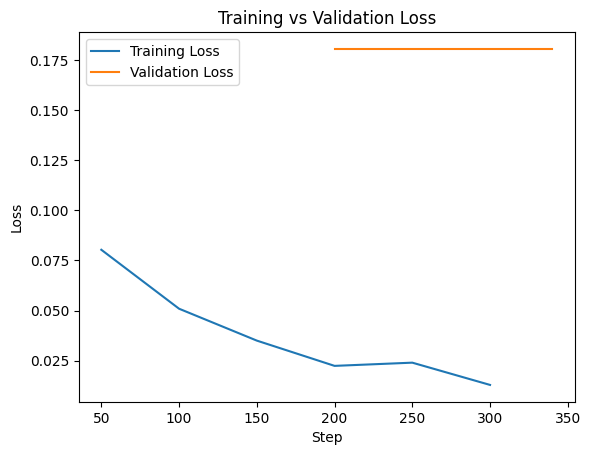

<Figure size 640x480 with 0 Axes>

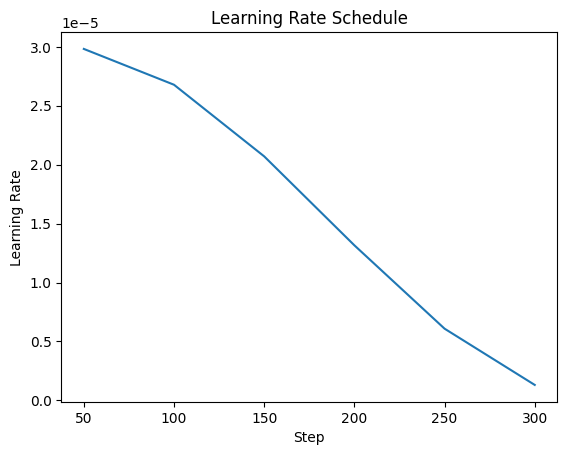

In [71]:
train_logs = logs.loc[logs["loss"].notna()]
val_logs = logs.loc[logs["eval_loss"].notna()]
# Training Loss vs Step
plt.figure()
plt.plot(train_logs["step"], train_logs["loss"], label="Training Loss")
plt.plot(val_logs["step"], val_logs["eval_loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()
# Learning Rate Schedule
plt.figure()
logs.loc[logs["learning_rate"].notna()].plot(x="step", y="learning_rate", kind="line", legend=False)
plt.title("Learning Rate Schedule")
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

# Submit

In [57]:
%%time

test['text'] = test.apply(make_prompt,axis=1)

ds_test = Dataset.from_pandas(test[['text']])
ds_test = ds_test.map(tokenize, batched=True)

predictions = trainer.predict(ds_test)
probs = torch.sigmoid(torch.tensor(predictions.predictions)).numpy().flatten()

sub = pd.DataFrame({
    "row_id": test.row_id.values,
    "rule_violation": probs
})
sub.to_csv("submission.csv", index=False)
sub.head()

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

CPU times: user 361 ms, sys: 16.1 ms, total: 377 ms
Wall time: 285 ms


,row_id,rule_violation
0,2029,0.499340
1,2030,0.725201
2,2031,0.731603
3,2032,0.734574
4,2033,0.746937
